# KMeans clustering tokenizer

In [ ]:
import os

os.chdir("../..")

In [23]:
import numpy as np
import torch
from torch.utils.data import DataLoader

from dataset import QuickDrawDataset
from utils import svg_strokes_to_tensor_quantized, tensor_to_svg_strokes
from tqdm import tqdm

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)

Using device: cuda


In [ ]:
label_names = ["cat", "dog", "airplane"]


def to_tensor_quantized_64(svg_content):
    return svg_strokes_to_tensor_quantized(svg_content, bins=64).to(dtype=torch.int8)


data = QuickDrawDataset(label_names=label_names, download=True)


class SketchDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        return to_tensor_quantized_64(self.base_dataset[idx])


training_data = SketchDatasetWrapper(data)

Loading QuickDraw files: 100%|██████████| 3/3 [00:09<00:00,  3.30s/it]


In [26]:
print(training_data[0].shape)  # torch.Size([200, 3])
print(len(training_data))
loader = DataLoader(training_data, batch_size=32, shuffle=False, pin_memory=True)
# loader = cycle(loader)


def normalize_strokes(batch, scale=128.0):
    batch = batch.clone().float()
    # Normalize delta x, delta y
    batch[..., 0:2] = batch[..., 0:2] / scale
    # Leave pen_state as is (0, 1)
    return batch


def denormalize_strokes(batch, scale=128.0):
    batch = batch.clone()
    batch[..., 0:2] = (batch[..., 0:2] * scale).round().to(dtype=torch.int8)
    return batch

torch.Size([200, 3])
382139


In [27]:
import os
import numpy as np
from sklearn.cluster import KMeans
import pickle


def save_pickle(path, obj):
    with open(path, "wb") as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


data0 = []  # points with penstate=0
data1 = []  # points with penstate=1

for batch in tqdm(loader):
    batch = batch.to(device)
    batch = normalize_strokes(batch, scale=64.0)
    batch = batch.view(-1, 3).cpu().numpy()
    # Exclude rows where dx, dy, and penstate are all zero
    mask_nonzero = ~np.all(batch == 0, axis=1)
    batch = batch[mask_nonzero]
    # Separate by penstate
    mask0 = batch[:, 2] == 0
    mask1 = batch[:, 2] == 1
    data0.append(batch[mask0][:, :2])
    data1.append(batch[mask1][:, :2])


data0 = np.concatenate(data0, axis=0)
data1 = np.concatenate(data1, axis=0)
N_P0, N_P1 = data0.shape[0], data1.shape[0]

p1_ratio = 0.2

n_p1 = int(p1_ratio * len(training_data))
n_p0 = len(training_data) - n_p1
if N_P0 > n_p0:
    print(f"Sample {n_p0} out of {N_P0} points with penstate 0")
    ids_p0 = np.random.choice(N_P0, n_p0, replace=False)
    data_p0 = data0[ids_p0]
if N_P1 > n_p1:
    print(f"Sample {n_p1} out of {N_P1} points with penstate 1")
    ids_p1 = np.random.choice(N_P1, n_p1, replace=False)
    data_p1 = data1[ids_p1]
data = np.r_[data_p0, data_p1]


vocab_size = 2048
model = "data/quickdraw_64bins_kmeans_tokenizer.pkl"

if os.path.exists(model):
    print(f"Loading existing tokenizer from {model}")
    with open(model, "rb") as f:
        cluster = pickle.load(f)
else:
    cluster = KMeans(n_clusters=vocab_size, n_init=10, max_iter=500, tol=1e-6).fit(data)
    save_pickle(model, cluster)

100%|██████████| 11942/11942 [00:06<00:00, 1892.39it/s]


Sample 305712 out of 2506295 points with penstate 0
Sample 76427 out of 17054147 points with penstate 1
Loading existing tokenizer from data/quickdraw_64bins_kmeans_tokenizer.pkl


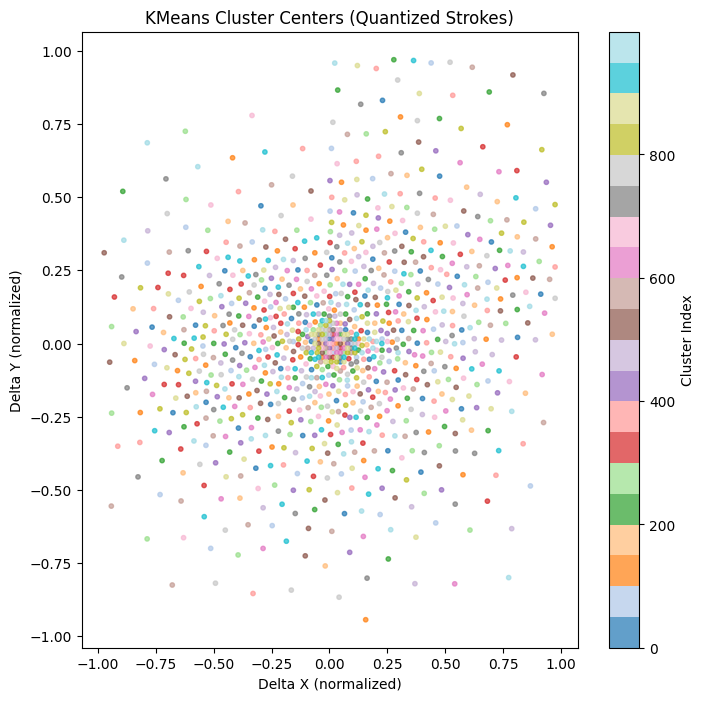

In [28]:
# Visualize clusters from KMeans
# Goal have the model predict the cluster index (0 to 1000) instead of dx, dy directly

import matplotlib.pyplot as plt

data = cluster.cluster_centers_
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], s=10, c=range(len(data)), cmap="tab20", alpha=0.7)
plt.title("KMeans Cluster Centers (Quantized Strokes)")
plt.xlabel("Delta X (normalized)")
plt.ylabel("Delta Y (normalized)")
plt.colorbar(label="Cluster Index")
plt.show()

In [ ]:
# Tokenize a datapoint
svg_content = training_data[0]
normalized_strokes = normalize_strokes(svg_content, scale=64.0)
token_indices = cluster.predict(normalized_strokes[:, :2].cpu().numpy())
token_indices = torch.from_numpy(token_indices).to(dtype=torch.long)
# print(token_indices)

# reconstruct from tokens
reconstructed_points = cluster.cluster_centers_[token_indices.cpu().numpy()]

# take pen state from original
reconstructed_strokes = np.zeros_like(normalized_strokes.cpu().numpy())
reconstructed_strokes[:, :2] = reconstructed_points
reconstructed_strokes[:, 2] = normalized_strokes[:, 2]

reconstructed_strokes = denormalize_strokes(
    torch.from_numpy(reconstructed_strokes), scale=64.0
)
# print(reconstructed_strokes)

print("Reconstruction using tokenizer (KMeans clusters)")

from IPython.display import HTML, display

original_svg = tensor_to_svg_strokes(svg_content, size=64)
reconstructed_svg = tensor_to_svg_strokes(reconstructed_strokes, size=64)

svgs_inline = f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Original</b><br>{original_svg}</div>'
svgs_inline += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Reconstructed</b><br>{reconstructed_svg}</div>'
display(HTML(svgs_inline))

Reconstruction using tokenizer (KMeans clusters)


In [ ]:
# Instead of using clustering what if we used a very large dictionary for perfect reconstruction?